In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random

In [2]:
!kaggle datasets download -d adarshpathak/shakespeare-text

Dataset URL: https://www.kaggle.com/datasets/adarshpathak/shakespeare-text
License(s): unknown
100% 432k/432k [00:00<00:00, 542kB/s]
100% 432k/432k [00:00<00:00, 541kB/s]


In [3]:
!unzip shakespeare-text.zip

Archive:  shakespeare-text.zip
  inflating: text.txt                


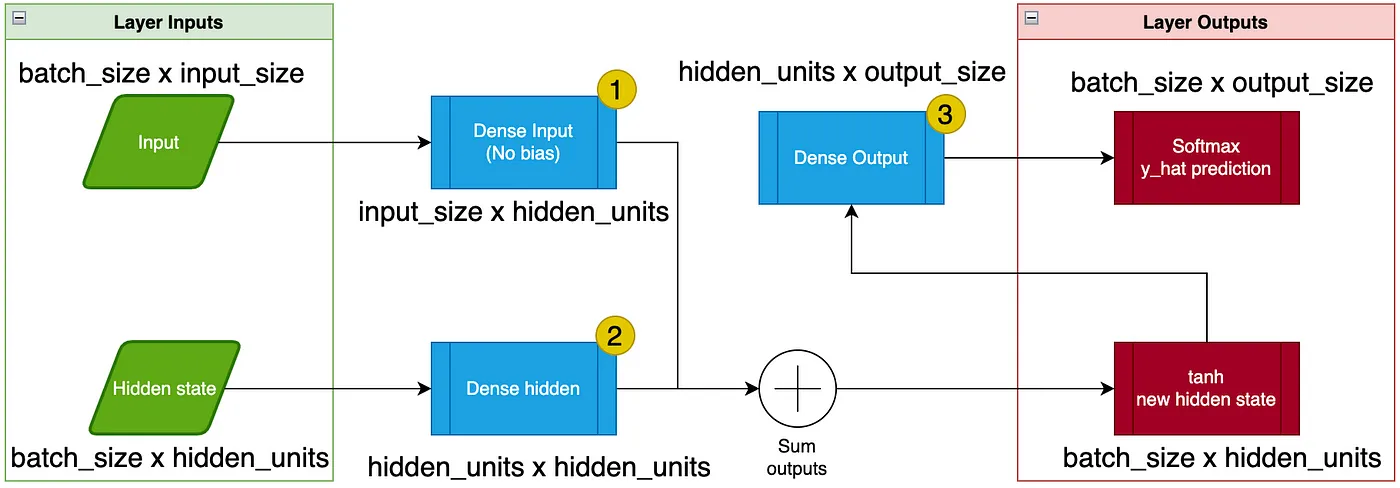

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device")

Using 'cuda' device


In [6]:
class RNN(nn.Module):
  def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
    """
    input_size: Number of features of your input vector
    hidden_size: Number of hidden neurons
    output_size: Number of features of your output vector
    """
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.batch_size = batch_size

    self.i2h = nn.Linear(input_size, hidden_size, bias=False)
    self.h2h = nn.Linear(hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden_state) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Returns computed output and tanh(i2h + h2h)
    Inputs
    ------
    x: Input vector
    hidden_state: Previous hidden state
    Outputs
    -------
    out: Linear output (without activation because of how pytorch works)
    hidden_state: New hidden state matrix
    """
    x = self.i2h(x)
    hidden_state = self.h2h(hidden_state)
    hidden_state = torch.tanh(x + hidden_state)
    out = self.h2o(hidden_state)
    return out, hidden_state

  def init_zero_hidden(self, batch_size=1) -> torch.Tensor:
    return torch.zeros(batch_size, self.hidden_size, requires_grad=False)


In [12]:
def train(model: RNN, data: DataLoader, epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module) -> None:
  train_losses = {}
  model.to(device)

  model.train()
  print("=> Starting training")
  for epoch in range(epochs):
    epoch_losses = list()
    for X, Y in data:
      # skip last batch if it doesnt match with the batch_size
      if X.shape[0] != model.batch_size:
        continue
      hidden = model.init_zero_hidden(batch_size=model.batch_size)
      X, Y, hidden = X.to(device), Y.to(device), hidden.to(device)
      model.zero_grad()
      loss = 0
      for c in range(X.shape[1]):
        out, hidden = model(X[:, c].reshape(X.shape[0], 1), hidden)
        l = loss_fn(out, Y[:, c].long())
        loss += l

      loss.backward()
      # Adjust learnable parameters
      # clip as well to avoid vanishing and exploding gradients
      nn.utils.clip_grad_norm_(model.parameters(), 3)
      optimizer.step()
      epoch_losses.append(loss.detach().item() / X.shape[1])

    train_losses[epoch] = torch.tensor(epoch_losses).mean()
    print(f'=> epoch: {epoch + 1}, loss: {train_losses[epoch]}')
    print(generate_text(model, data.dataset))



In [14]:
def generate_text(model: RNN, dataset: TextDataset, prediction_length: int = 100) -> str:
    """
    Generate text up to prediction_length characters
    This function requires the dataset as argument in order to properly
    generate the text and return the output as strings
    """
    model.eval()
    predicted = dataset.vector_to_string([random.randint(0, len(dataset.chars) -1)])
    hidden = model.init_zero_hidden()

    for i in range(prediction_length - 1):
        last_char = torch.Tensor([dataset.char_to_idx[predicted[-1]]])
        X, hidden = last_char.to(device), hidden.to(device)
        out, hidden = model(X, hidden)
        result = torch.multinomial(nn.functional.softmax(out, 1), 1).item()
        #result = out.argmax().item()
        predicted += dataset.idx_to_char[result]

    return predicted

In [9]:
"""
Data preparation
"""
class TextDataset(Dataset):
    """
    Text Dataset
    Text Dataset Class

    This class is in charge of managing text data as vectors
    Data is saved as vectors (not as text)
    Attributes
    ----------
    seq_length - int: Sequence length
    chars - list(str): List of characters
    char_to_idx - dict: dictionary from character to index
    idx_to_char - dict: dictionary from index to character
    vocab_size - int: Vocabulary size
    data_size - int: total length of the text
    """
    def __init__(self, text_data: str, seq_length: int = 25) -> None:
        """
        Inputs
        ------
        text_data: Full text data as string
        seq_length: sequence length. How many characters per index of the dataset.
        """
        self.chars = sorted(list(set(text_data)))
        self.data_size, self.vocab_size = len(text_data), len(self.chars)
        # useful way to fetch characters either by index or char
        self.idx_to_char = {i:ch for i, ch in enumerate(self.chars)}
        self.char_to_idx = {ch:i for i, ch in enumerate(self.chars)}
        self.seq_length = seq_length
        self.X = self.string_to_vector(text_data)

    @property
    def X_string(self) -> str:
        """
        Returns X in string form
        """
        return self.vector_to_string(self.X)

    def __len__(self) -> int:
        """
        We remove the last sequence to avoid conflicts with Y being shifted to the left
        This causes our model to never see the last sequence of text
        which is not a huge deal, but its something to be aware of
        """
        return int(len(self.X) / self.seq_length -1)

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        """
        X and Y have the same shape, but Y is shifted left 1 position
        """
        start_idx = index * self.seq_length
        end_idx = (index + 1) * self.seq_length

        X = torch.tensor(self.X[start_idx:end_idx]).float()
        y = torch.tensor(self.X[start_idx+1:end_idx+1]).float()
        return X, y

    def string_to_vector(self, name: str) -> list[int]:
        """
        Converts a string into a 1D vector with values from char_to_idx dictionary
        Inputs
        name: Name as string
        Outputs
        name_tensor: name represented as list of integers (1D vector)
        sample:
        >>> string_to_vector('test')
        [20, 5, 19, 20]
        """
        vector = list()
        for s in name:
            vector.append(self.char_to_idx[s])
        return vector

    def vector_to_string(self, vector: list[int]) -> str:
        """
        Converts a 1D vector into a string with values from idx_to_char dictionary
        Inputs
        vector: 1D vector with values in the range of idx_to_char
        Outputs
        vector_string: Vector converted to string
        sample:
        >>> vector_to_string([20, 5, 19, 20])
        'test'
        """
        vector_string = ""
        for i in vector:
            vector_string += self.idx_to_char[i]
        return vector_string


In [23]:
if __name__ == "__main__":
    data = open('/content/text.txt', 'r').read() # use any text file you want to learn
    data = data.lower()

    # Data size variables
    seq_length = 50
    batch_size = 64
    hidden_size = 256

    text_dataset = TextDataset(data, seq_length=seq_length)
    text_dataloader = DataLoader(text_dataset, batch_size)

    # Model
    rnnModel = RNN(1, hidden_size, len(text_dataset.chars)) # 1 because we enter a single number/letter per step.

    # Train variables
    epochs = 1000
    loss = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(rnnModel.parameters(), lr = 0.001)

    train(rnnModel, text_dataloader, epochs, optimizer, loss)

=> Starting training
=> epoch: 1, loss: 2.692458152770996
'ouyrl.
whathse teg auwr moa, wies
oo totoe nelcpsln ro sord fle nooidl.

lroi orasrbir:- gorant:t w


KeyboardInterrupt: 